In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('bank-full.csv', sep=';')

columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
df = df[columns]

df['y'] = df['y'].map({'yes': 1, 'no': 0})

X = df.drop('y', axis=1)
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

Вопрос 1 Важность признаков по ROC AUC

In [3]:
from sklearn.metrics import roc_auc_score

numerical_features = ['age', 'balance', 'day', 'duration', 'previous']

auc_scores = {}

for feature in numerical_features:
    auc = roc_auc_score(y_train, X_train[feature])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feature])
        auc_scores[feature] = auc

    else:
        auc_scores[feature] = auc

sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
print(f"Наивысший AUC: {sorted_auc[0]}")

Наивысший AUC: ('duration', 0.8128648066681694)


Вопрос 2 Обучение модели

In [4]:

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

dict_vectorizer = DictVectorizer(sparse=False)

X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

X_train_encoded = dict_vectorizer.fit_transform(X_train_dict)
X_val_encoded = dict_vectorizer.transform(X_val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)

print(f"AUC на валидационном наборе: {auc:.3f}")


AUC на валидационном наборе: 0.900


Вопрос 3 Точность и полнота

Порог, при котором Precision и Recall пересекаются: 0.289


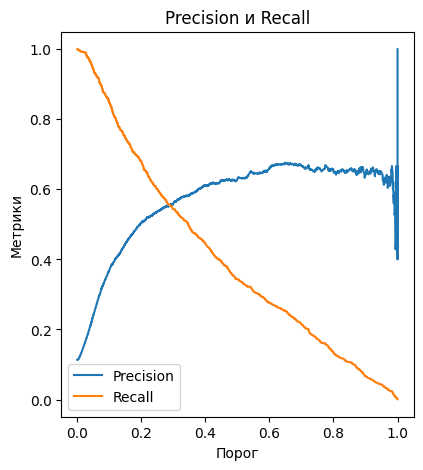

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Порог')
plt.ylabel('Метрики')
plt.title('Precision и Recall')
plt.legend()

intersection_threshold = thresholds[abs(precision - recall).argmin()]
print(f"Порог, при котором Precision и Recall пересекаются: {intersection_threshold:.3f}")

Вопрос 4 F1 score

In [6]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(y_val, y_val_pred > threshold) for threshold in thresholds]

best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Порог для максимального F1: {best_threshold:.3f}")

Порог для максимального F1: 0.199


Вопрос 5 5-кратная кросс-валидация

In [7]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_kfold = []

for train_index, val_index in kf.split(X_train_encoded):
    X_train_fold, X_val_fold = X_train_encoded[train_index], X_train_encoded[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)

    y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_val_pred_fold)
    auc_scores_kfold.append(auc_fold)

std_error = np.std(auc_scores_kfold)
print(f"Стандартная ошибка: {std_error:.3f}")

Стандартная ошибка: 0.004


Вопрос 6 Тюнинг гиперпараметров

In [8]:
C_values = [0.000001, 0.001, 1]

mean_aucs = []
std_aucs = []

for C in C_values:
    auc_scores_C = []

    for train_index, val_index in kf.split(X_train_encoded):
        X_train_fold, X_val_fold = X_train_encoded[train_index], X_train_encoded[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        y_val_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_val_pred_fold)
        auc_scores_C.append(auc_fold)

    mean_auc = np.mean(auc_scores_C)
    std_auc = np.std(auc_scores_C)

    mean_aucs.append(mean_auc)
    std_aucs.append(std_auc)

best_C = C_values[np.argmax(mean_aucs)]
best_std_error = min(std_aucs)

print(f"Лучшее значение C: {best_C}, Среднее AUC: {mean_aucs[np.argmax(mean_aucs)]:.3f}, Стандартная ошибка: {best_std_error:.3f}")


Лучшее значение C: 1, Среднее AUC: 0.908, Стандартная ошибка: 0.004
